In [1]:
%matplotlib inline

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detector_v2 import CornerDetector
from utils.centre_point_box import get_centre_point_boxex, draw_centre_points
from utils.preprocessing import warp_image_with_centres

In [3]:
detector = CornerDetector('models/corner_detector_v2.1.pt') 
detector.device_info()

Model summary: 129 layers, 11,137,148 parameters, 0 gradients, 28.7 GFLOPs
Is GPU available?: True
GPU count: 1
Device name: NVIDIA GeForce GTX 1070


In [4]:
metrics = detector.evaluate('./dataset_v2/data.yaml')
print(f'\nPrecision: {metrics['mean_precision']}')
print(f'Recall: {metrics['mean_recall']}')
print(f'mAP50: {metrics['mean_mAP50']}')
print(f'mAP50-95: {metrics['mean_mAP50-95']}')

Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning F:\CV_Project\src\modules\corner_detector\dataset_v2\valid\labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


                   all        105        402       0.94      0.934      0.948      0.505
           bottom-left        103        105      0.924      0.933      0.931      0.522
          bottom-right        102        102       0.95      0.961      0.963      0.529
              top-left        103        103      0.956      0.961      0.972      0.491
             top-right         91         92      0.931      0.879      0.927      0.478
Speed: 0.9ms preprocess, 10.5ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs\detect\val33

Precision: 0.9401036872622397
Recall: 0.9336080647920764
mAP50: 0.9479974749911609
mAP50-95: 0.5049731509326021


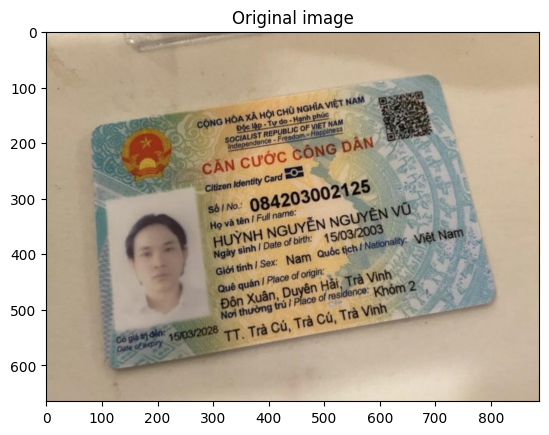

In [5]:
IMG_PATH = 'test_img2.jpg'
img = cv2.imread(IMG_PATH)
plt.title('Original image')
plt.imshow(img[:,:,::-1])
plt.show()

In [6]:
result = detector.predict(IMG_PATH, save=True)


image 1/1 f:\CV_Project\src\modules\corner_detector\test_img2.jpg: 480x640 1 bottom-left, 1 bottom-right, 1 top-left, 1 top-right, 76.8ms
Speed: 4.5ms preprocess, 76.8ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict20


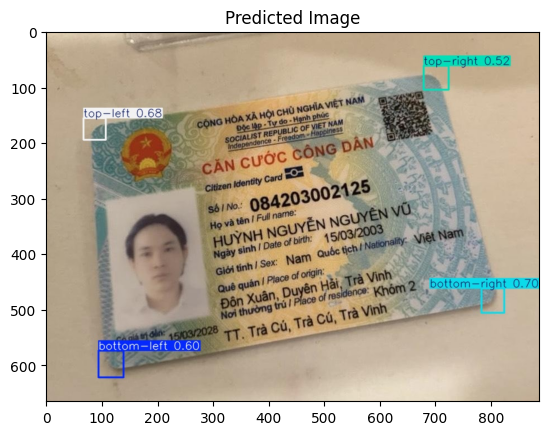

In [7]:
predicted_img = cv2.imread(os.path.join(result[0].save_dir, IMG_PATH))
plt.title('Predicted Image')
plt.imshow(predicted_img[:,:,::-1])
plt.show()

Center: (804.2035827636719, 484.9175109863281)
Center: (87.59877395629883, 176.33081817626953)
Center: (116.76150131225586, 598.881591796875)
Center: (702.0332946777344, 83.99392509460449)


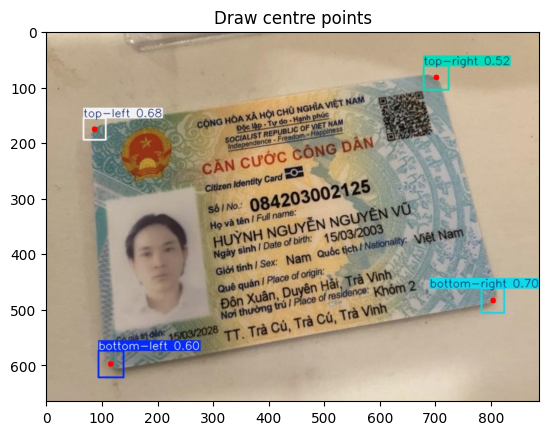

In [8]:
centre_points = get_centre_point_boxex(result[0].boxes)
drawed_img = draw_centre_points(predicted_img, centre_points)

plt.title('Draw centre points')
plt.imshow(drawed_img)
plt.show()

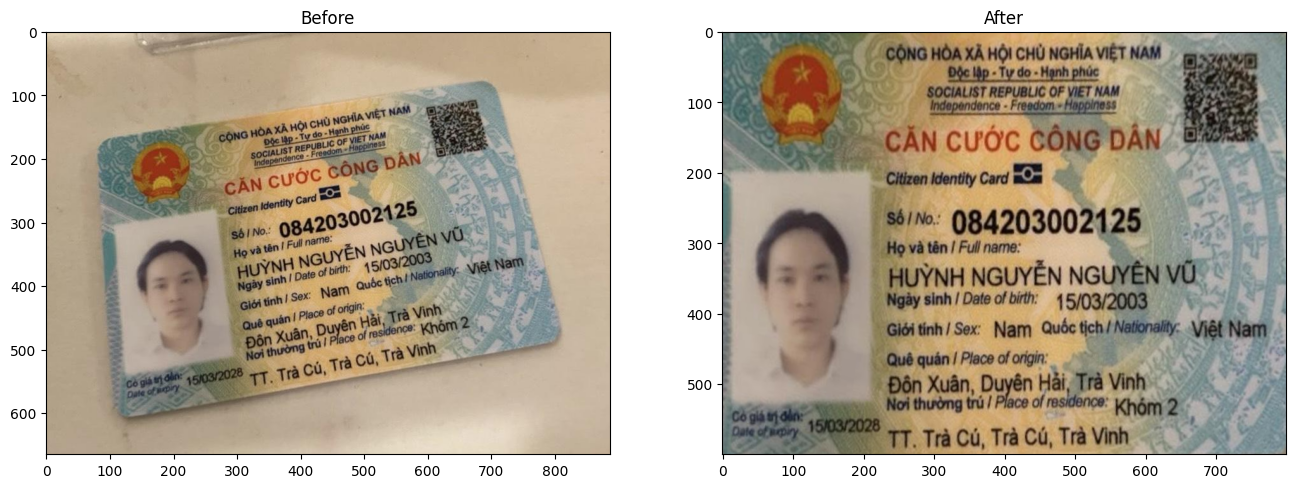

In [9]:
origin_img = cv2.imread(IMG_PATH)
wrapped_img = warp_image_with_centres(img, centre_points, output_size=(800, 600))

plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.imshow(origin_img[:,:,::-1])
plt.title('Before')

plt.subplot(1, 2, 2)
plt.imshow(wrapped_img[:,:,::-1])
plt.title('After')

plt.show()

In [10]:
%cd F://CV_Project/src/modules
from fields_recognition.detector import FieldDetector

F:\CV_Project\src\modules


In [11]:
new_img = wrapped_img
field_detector = FieldDetector('../fields_recognition/cccdYoloV8.pt')

Model summary: 129 layers, 3,012,603 parameters, 0 gradients, 8.2 GFLOPs


In [12]:
results = field_detector.predict(new_img)


0: 480x640 1 id, 1 full_name, 1 date_of_birth, 1 sex, 1 nationality, 1 place_of_origin, 2 place_of_residences, 1 date_of_expiry, 1 qr_code, 52.7ms
Speed: 3.7ms preprocess, 52.7ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


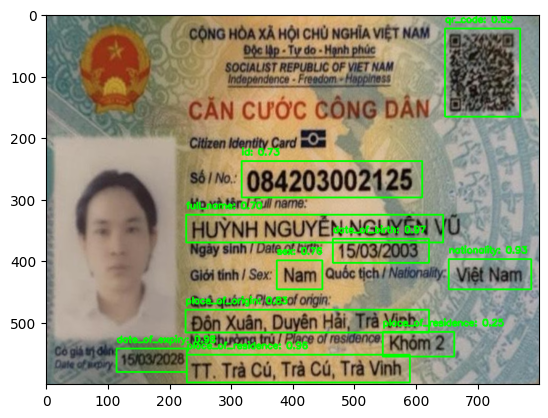

In [13]:
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Lấy toạ độ (x1, y1, x2, y2)
        confidence = box.conf[0].item()  # Lấy độ chính xác
        class_id = int(box.cls[0])  # Lấy ID của class
        label = f"{field_detector.get_model().names[class_id]}: {confidence:.2f}"  # Tạo label

        # Vẽ bounding box lên ảnh
        cv2.rectangle(new_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Màu xanh lá, độ dày 2px
        cv2.putText(new_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(new_img[:,:,::-1])